# Stability (a case study)

Broadly speaking, stability refers to the sensitivity of an algorithm to perturbations. Since our algorithms are performed in double precision arithmetic, they are constantly undergoing small perturbations. If the result is more strongly affected by these than the conditioning of the underlying problem suggests, then we call the algorithm unstable.

## Quadratic formula

Consider a polynomial whose roots are widely separated in scales.

In [9]:
using Polynomials, LinearAlgebra
p = poly([1.0e-6,1.0e6])

Poly(1.0 - 1.000000000001e6*x + 1.0*x^2)

The roots of this polynomial are well conditioned with respect to perturbations in its coefficients. 

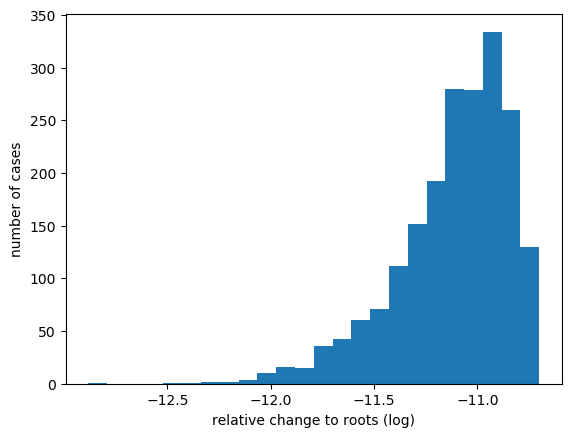

In [10]:
delta = [];
r = sort(roots(p));
for j = 1:2000
    pp = p + 1e-11*Poly( p.a.*(2*rand(3).-1) )
    rr = roots(pp)
    global delta = [ delta; norm( (sort(real(rr))-r)./r, Inf ) ];
end
using PyPlot
plt[:hist](log.(10,delta),24);
xlabel("relative change to roots (log)"); ylabel("number of cases");

According to this experiment, we should be able to compute the polynomial roots accurately in floating point. 

Let's return to middle school and apply the quadratic formula to find the roots. First is the discriminant.

In [11]:
c,b,a = p.a
d = sqrt(b^2-4*a*c)

999999.999999

And now, the roots.

In [13]:
@show r1 = (-b+d)/(2a);
@show r2 = (-b-d)/(2a);

r1 = (-b + d) / (2a) = 1.0e6
r2 = (-b - d) / (2a) = 1.00000761449337e-6


WTF? The r2 result has just 5 accurate digits:

In [14]:
-log(10,abs(r2-1e-6)/1e-6)

5.118358987126217

While multiplication and division are perfectly conditioned operations, addition/subtraction are not when cancellation is involved; the condition number in the infinity norm is inversely related to the absolute value of the result.

In [15]:
s = -b-d;
@show κ = 2*norm([-b,d],Inf)/abs(s);

κ = (2 * norm([-b, d], Inf)) / abs(s) = 9.9999238556561e11


The condition number of a series of calculations is the product of the condition numbers of the steps (basically, the chain rule). By introducing this step into the process, we get a condition number of about $10^{10}$ in the calculation, rather than the underlying problem's condition number, which is close to 1. 

We can avoid this ill-conditioned step by using the identity

$$r_1r_2 = \frac{c}{a}$$

to compute the smaller root accurately.

In [16]:
c/(a*r1) - 1.0e-6

0.0

## Three levels of performance

Ultimately we would like **accuracy**, that is, as small an error as the machine allows. For poorly conditioned problems, this is not a realistic expectation. Instead, we can hope for a small **backward error**, which is the distance between the original data and the data that produces the result we actually computed. 

It's interesting to check the backward error of our "bad" root calculation. One polynomial whose exact roots were found is

In [17]:
pp = poly([r1,r2])

Poly(1.00000761449337 - 1.000000000001e6*x + 1.0*x^2)

All polynomials with these roots are multiples of this one. We can find the one that's closest to the original data of the problem using a linear least squares calculation:

In [18]:
α = pp.a\p.a

Hence the minimal (2-norm) difference in coefficients is

In [21]:
@show (p.a - α*pp.a)

p.a - α * pp.a = [-7.61449e-6, -1.16415e-10, 1.11022e-16]


3-element Array{Float64,1}:
 -7.614493369834108e-6  
 -1.1641532182693481e-10
  1.1102230246251565e-16

The second and third values are both $\mathcal{O}(\epsilon_M)$ with respect to the original polynomial coefficients, but the one from the polynomial constant term is not. The backward error here, like the forward error, is $\mathcal{O}(10^{-5})$.

An algorithm that can guarantee a small backward error is **backward stable**. The accuracy of a backward stable algorithm is proportional jointly to the condition number of its problem and the machine precision.

Finally, even backward stability is not always realistic. For example, if a result is supposed to have a particular structure, like symmetry or orthogonality, we cannot hope that the perturbations of floating point representation will preserve that structure. Hence no data could have produced it exactly. Instead we have to look for nearby data that would produce a nearby result having the required structure. Algorithms that can guarantee such situations are called **stable**. In some computations that is all we can assert. 